In [15]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
ticker = 'AAPL'

df = yf.download(ticker, start='2010-01-01', end='2025-06-25')

/tmp/ipykernel_63940/3262008318.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2010-01-01', end='2025-06-25')
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

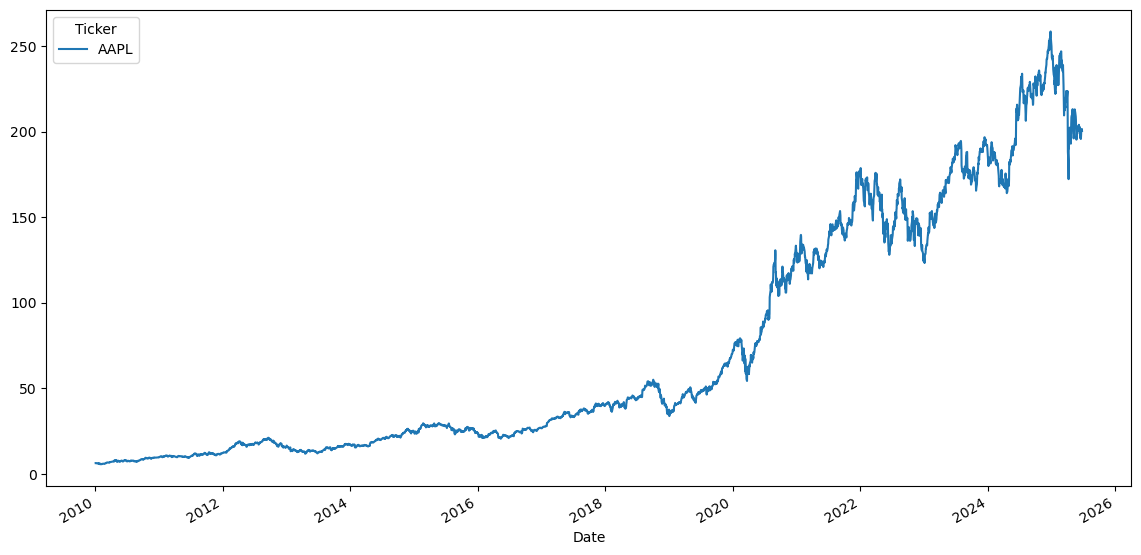

In [6]:
df.Close.plot(figsize=(14, 7))

In [7]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df[['Close']])

In [8]:
df.Close

Ticker,AAPL
Date,
2010-01-04,-0.943264
2010-01-05,-0.943104
2010-01-06,-0.944580
2010-01-07,-0.944748
2010-01-08,-0.944143
...,...
2025-06-17,1.780295
2025-06-18,1.793826
2025-06-20,1.857449


In [9]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
  data.append(df['Close'][i:i + seq_length])

data = np.array(data)

In [18]:
train_size = int(len(data) * 0.8)

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [19]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [20]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
num_epochs = 200

for i in tqdm(range(num_epochs)):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(f'Epoch {i}, Loss: {loss.item()}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  7%|▋         | 14/200 [00:00<00:02, 72.53it/s]

Epoch 0, Loss: 0.44870638847351074


 20%|██        | 40/200 [00:00<00:01, 107.63it/s]

Epoch 25, Loss: 0.006998310796916485
Epoch 50, Loss: 0.0007755133556202054


 46%|████▌     | 92/200 [00:00<00:00, 124.29it/s]

Epoch 75, Loss: 0.0005935540539212525
Epoch 100, Loss: 0.0005478211096487939


 72%|███████▏  | 144/200 [00:01<00:00, 126.64it/s]

Epoch 125, Loss: 0.0005251544644124806
Epoch 150, Loss: 0.0005078353569842875


100%|██████████| 200/200 [00:01<00:00, 118.56it/s]

Epoch 175, Loss: 0.0004946690169163048


In [23]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [24]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [26]:
train_rmse, test_rmse

(1.5281589031219482, 7.858907222747803)

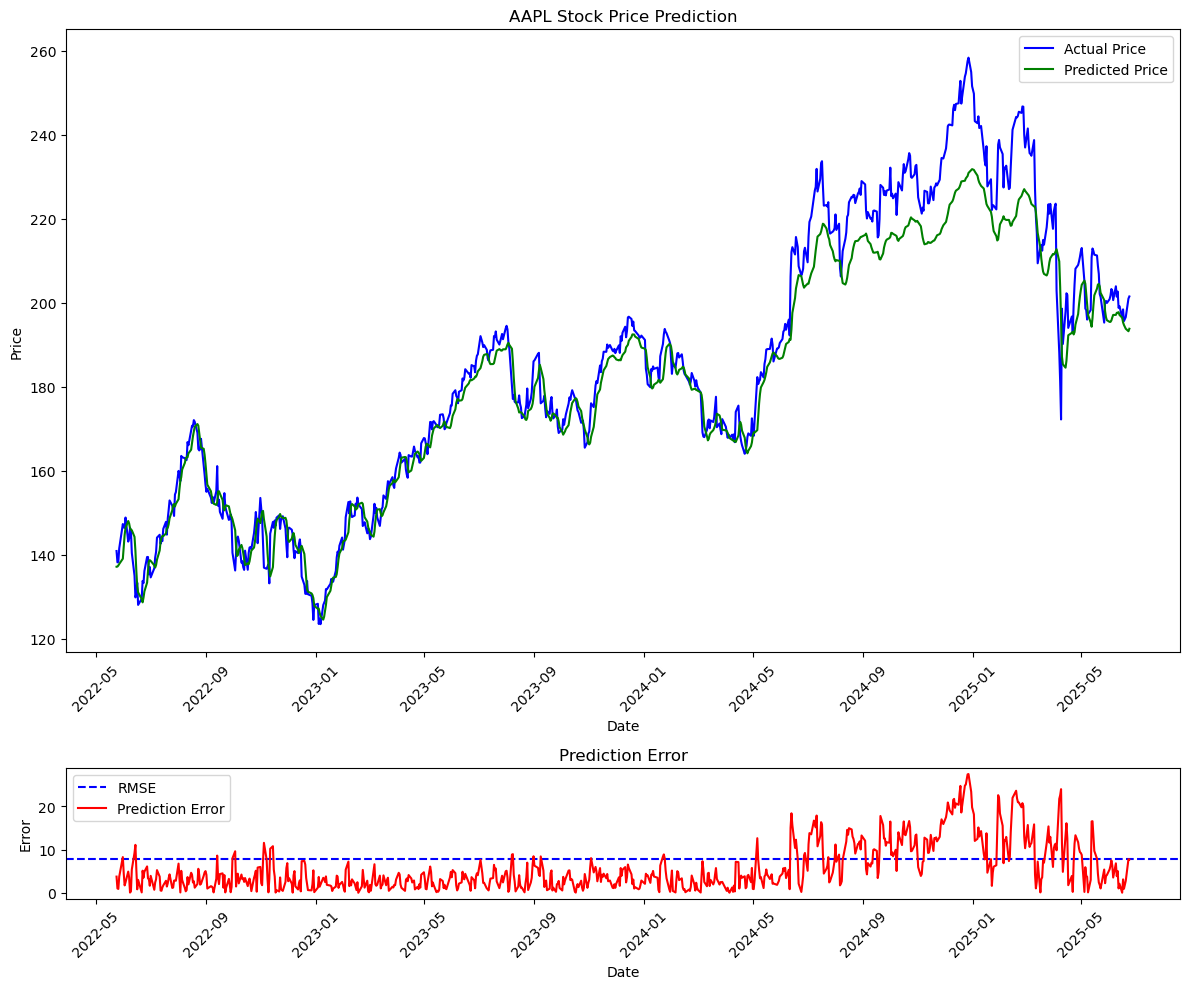

In [27]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Predicted Price')
ax1.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), color='red', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Lưu lại mô hình

In [28]:
torch.save(model.state_dict(), 'lstm_model.pth')

# Load lại mô hình

In [ ]:
model.load_state_dict(torch.load('model_checkpoint.pth', map_location=device))
# Chuyển sang chế độ eval để inference
model.eval()